# XGBoost Models | with feature selection and normalized data

**XGBRegressor**

Josie Donnelly

*Last updated 11.21.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time
import random
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor


## Preprocessing

In [2]:
dim = 10
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = f'final_norm_set_{dim}.csv'
df_orig = pd.read_csv(path + file)
df_orig


,float,cycleNumber,latitude,longitude,date_doy_rad,sat_chl_month,sat_sst_month,sat_par_month,sat_pic_month,sat_aph_443_month,...,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6,norm_7,norm_8,norm_9,cluster_val
0,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,39.556000,0.000184,0.0419,...,0.666205,1.012206,0.684214,0.267952,0.111618,0.079771,0.035588,0.028574,0.017237,0
1,1902303,2,49.096,-14.617,2.167505,0.782180,12.466026,42.348000,0.000188,0.0405,...,0.769805,1.421664,0.499703,0.164590,0.101823,0.077022,0.039846,0.029488,0.017669,0
2,1902303,3,48.914,-14.606,2.184708,0.458020,12.424099,44.795998,0.000144,0.0358,...,0.958217,1.208600,0.747428,0.275769,0.121542,0.069676,0.051542,0.024415,0.016029,0
3,1902303,4,48.794,-14.689,2.201910,0.378064,12.374519,43.792000,0.000098,0.0353,...,1.408329,1.494241,1.371946,0.516033,0.115721,0.063536,0.040337,0.026592,0.024358,0
4,1902303,5,48.719,-14.795,2.219113,0.411479,12.204494,42.143997,0.000176,0.0244,...,1.046583,1.040288,0.747365,0.074409,0.032036,0.032410,0.032977,0.023378,0.013801,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42333,7901001,10,17.103,-24.442,1.376194,0.327877,21.746379,51.337997,0.000010,0.0183,...,0.284199,0.275597,0.183173,0.177468,0.090622,0.057700,0.051305,0.009273,0.007097,2
42334,7901001,11,17.131,-24.170,1.410599,0.390988,21.762587,49.129997,0.000010,0.0213,...,0.186065,0.185515,0.158747,0.112381,0.062951,0.043956,0.046166,0.012392,0.002762,2
42335,7901001,12,16.968,-23.922,1.445004,0.208484,21.850749,50.998001,0.000042,0.0128,...,0.063278,0.139967,0.252586,0.193886,0.109652,0.066035,0.023961,0.010345,0.003394,2
42336,7901001,13,16.803,-23.778,1.479408,0.162081,21.975307,50.112000,0.000010,0.0106,...,0.035424,0.097762,0.173301,0.262650,0.122012,0.063013,0.035242,0.011037,0.002808,2


In [3]:
' '.join(list(df_orig.columns))

'float cycleNumber latitude longitude date_doy_rad sat_chl_month sat_sst_month sat_par_month sat_pic_month sat_aph_443_month depth_bin_0 depth_bin_1 depth_bin_2 depth_bin_3 depth_bin_4 depth_bin_5 depth_bin_6 depth_bin_7 depth_bin_8 depth_bin_9 depth_bin_10 depth_bin_11 depth_bin_12 depth_bin_13 depth_bin_14 depth_bin_15 depth_bin_16 depth_bin_17 depth_bin_18 depth_bin_19 depth_bin_20 depth_bin_21 depth_bin_22 depth_bin_23 depth_bin_24 depth_bin_25 depth_bin_26 depth_bin_27 depth_bin_28 depth_bin_29 depth_bin_30 depth_bin_31 depth_bin_32 depth_bin_33 depth_bin_34 depth_bin_35 depth_bin_36 depth_bin_37 depth_bin_38 depth_bin_39 depth_bin_40 depth_bin_41 depth_bin_42 depth_bin_43 depth_bin_44 depth_bin_45 depth_bin_46 depth_bin_47 depth_bin_48 depth_bin_49 depth_bin_50 depth_bin_51 depth_bin_52 depth_bin_53 depth_bin_54 depth_bin_55 depth_bin_56 depth_bin_57 depth_bin_58 depth_bin_59 depth_bin_60 depth_bin_61 depth_bin_62 depth_bin_63 depth_bin_64 depth_bin_65 depth_bin_66 depth_bin_67 d

In [4]:
df = df_orig[['float', 'cycleNumber', 'latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_par_month', 'sat_aph_443_month'] + [f'norm_{i}' for i in range(dim)]]
df = df.rename(columns={'cycleNumber': 'cycle', 'date_doy_rad': 'day_of_year_rad'})
# sat_chl: chlorophyll-a concentration
# sat_sst: sea surface temperature
# sat_pic: calcite concentration
# sat_par: photosynthetically available radiation
# sat_aph_443: absorption due to phytoplankton (443 nm)

print(list(df.columns))


['float', 'cycle', 'latitude', 'longitude', 'day_of_year_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_par_month', 'sat_aph_443_month', 'norm_0', 'norm_1', 'norm_2', 'norm_3', 'norm_4', 'norm_5', 'norm_6', 'norm_7', 'norm_8', 'norm_9']


In [5]:
df.isna().sum()


float                0
cycle                0
latitude             0
longitude            0
day_of_year_rad      0
sat_chl_month        0
sat_sst_month        0
sat_pic_month        0
sat_par_month        0
sat_aph_443_month    0
norm_0               0
norm_1               0
norm_2               0
norm_3               0
norm_4               0
norm_5               0
norm_6               0
norm_7               0
norm_8               0
norm_9               0
dtype: int64

In [6]:
# ensure the rows of the dataframe are unique
df.shape[0] == df.drop_duplicates().shape[0]


True

In [7]:
chla_vals = []
norm_vals = []
for row in range(df.shape[0]):
    chla_vals += list(df.loc[row,[f'norm_{i}' for i in range(dim)]])
    norm_vals += [i/dim for i in range(dim)]
print(f'Length chla_vals: {len(chla_vals)}')


Length chla_vals: 423380


In [8]:
# pivot table longer so each normalized CHLA value is a true CHLA value for that observation
df = df.append([df]*(dim-1)).sort_values(by=['float', 'cycle'], axis=0, ascending=True, ignore_index=True)
print(df.shape[0])
df


423380


,float,cycle,latitude,longitude,day_of_year_rad,sat_chl_month,sat_sst_month,sat_pic_month,sat_par_month,sat_aph_443_month,norm_0,norm_1,norm_2,norm_3,norm_4,norm_5,norm_6,norm_7,norm_8,norm_9
0,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.704058,0.666205,1.012206,0.684214,0.267952,0.111618,0.079771,0.035588,0.028574,0.017237
1,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.704058,0.666205,1.012206,0.684214,0.267952,0.111618,0.079771,0.035588,0.028574,0.017237
2,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.704058,0.666205,1.012206,0.684214,0.267952,0.111618,0.079771,0.035588,0.028574,0.017237
3,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.704058,0.666205,1.012206,0.684214,0.267952,0.111618,0.079771,0.035588,0.028574,0.017237
4,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.704058,0.666205,1.012206,0.684214,0.267952,0.111618,0.079771,0.035588,0.028574,0.017237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423375,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.065700,0.065002,0.097332,0.163517,0.231888,0.084066,0.037856,0.023726,0.010674,0.003290
423376,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.065700,0.065002,0.097332,0.163517,0.231888,0.084066,0.037856,0.023726,0.010674,0.003290
423377,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.065700,0.065002,0.097332,0.163517,0.231888,0.084066,0.037856,0.023726,0.010674,0.003290
423378,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.065700,0.065002,0.097332,0.163517,0.231888,0.084066,0.037856,0.023726,0.010674,0.003290


In [9]:
df = df.drop(columns=[f'norm_{i}' for i in range(dim)])
df['norm'] = norm_vals
df['CHLA'] = chla_vals
df


,float,cycle,latitude,longitude,day_of_year_rad,sat_chl_month,sat_sst_month,sat_pic_month,sat_par_month,sat_aph_443_month,norm,CHLA
0,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.0,0.704058
1,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.1,0.666205
2,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.2,1.012206
3,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.3,0.684214
4,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.4,0.267952
...,...,...,...,...,...,...,...,...,...,...,...,...
423375,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.5,0.084066
423376,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.6,0.037856
423377,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.7,0.023726
423378,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.8,0.010674


## Train-test split

In [10]:
# read in pre-determined train-test-split
path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/data/'
file = 'float_sat_normalized_depth_train_test_split.csv'
train_test_split_df = pd.read_csv(path + file)
train_test_split_df = train_test_split_df[['float', 'cycleNumber', 'train']].rename(columns={'cycleNumber': 'cycle'})
train_test_split_df

# # create train-test-split grouped by float and cycle
# df.insert(loc=list(df.columns).index('cycleNumber')+1, column='float_cycle_id', value=[f'{df.loc[i,"float"]}_{df.loc[i,"cycleNumber"]}'for i in range(df.shape[0])])
# print(f'Number of float-cycle pairs: {len(np.unique(df["float_cycle_id"]))}')

# split data indices into train and test dataframes grouped by float_cycle_id
# from sklearn.model_selection import GroupShuffleSplit
# splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
# split = splitter.split(df, groups=df['float_cycle_id'])
# train_inds, test_inds = next(split)

# print(f'Number of train observations: {len(train_inds)}')
# print(f'Number of float-cycle observations: {len(test_inds)}')

# # obtain train and test dataframes
# train_df = df.loc[train_inds]
# test_df = df.loc[test_inds]

# # ensure that the train and test float cycles are distinct
# train_float_cycles = np.unique(train_df['float_cycle_id'])
# test_float_cycles = np.unique(test_df['float_cycle_id'])
# print(f'\nNumber of unique train float-cycles: {len(np.unique(train_float_cycles))}')
# print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
# print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


,float,cycle,train
0,1902303,1,1
1,1902303,2,1
2,1902303,3,1
3,1902303,4,1
4,1902303,6,1
...,...,...,...
55851,2902755,278,0
55852,2902755,298,0
55853,2902755,266,0
55854,2902755,270,0


In [11]:
# notice that different floats may be mentioned in each dataframes
print(f'Number of floats in features df: {len(np.unique(df["float"]))}')
print(f'Number of floats in train-test-split df: {len(np.unique(train_test_split_df["float"]))}')

# merge the two dataframes
df_with_label = df.merge(right=train_test_split_df, how='inner', on=['float', 'cycle'], copy=False)
print(f'\nNumber of floats in merged df: {len(np.unique(df_with_label["float"]))}')

print(f'\nShape: {df_with_label.shape}')
df_with_label


Number of floats in features df: 551
Number of floats in train-test-split df: 565

Number of floats in merged df: 551

Shape: (423380, 13)


,float,cycle,latitude,longitude,day_of_year_rad,sat_chl_month,sat_sst_month,sat_pic_month,sat_par_month,sat_aph_443_month,norm,CHLA,train
0,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.0,0.704058,1
1,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.1,0.666205,1
2,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.2,1.012206,1
3,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.3,0.684214,1
4,1902303,1,49.236,-14.742,2.167505,0.435093,12.451869,0.000184,39.556000,0.0419,0.4,0.267952,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
423375,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.5,0.084066,1
423376,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.6,0.037856,1
423377,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.7,0.023726,1
423378,7901001,14,16.648,-23.732,1.513813,0.179276,22.266691,0.000040,50.068001,0.0148,0.8,0.010674,1


In [12]:
# ensure the rows of the dataframe are unique, including between train and test
df_with_label.shape[0] == df_with_label.drop(columns='train').drop_duplicates().shape[0]


True

In [13]:
# obtain train and test dataframes
train_df = df_with_label[df_with_label['train']==1].reset_index(drop=True).drop(columns='train')
test_df = df_with_label[df_with_label['train']==0].reset_index(drop=True).drop(columns='train')

print(f'Number of train observations: {train_df.shape[0]}')
print(f'Number of test observations: {test_df.shape[0]}')

# ensure that the train and test float cycles are distinct
train_float_cycles = np.unique([f'{f}_{c}' for f,c in zip(list(train_df['float']), list(train_df['cycle']))])
test_float_cycles = np.unique([f'{f}_{c}' for f,c in zip(list(test_df['float']), list(test_df['cycle']))])
print(f'\nNumber of unique train float-cycles: {len(np.unique(train_float_cycles))}')
print(f'Number of unique test float-cycles: {len(np.unique(test_float_cycles))}')
print(f'Number of float-cycle pairs in both train and test sets: {len(np.intersect1d(train_float_cycles, test_float_cycles))}')


Number of train observations: 340230
Number of test observations: 83150

Number of unique train float-cycles: 34023
Number of unique test float-cycles: 8315
Number of float-cycle pairs in both train and test sets: 0


## Define functions

In [14]:
# function to join CHLA data onto satellite information based on lat, long, and date
def get_data_by_depth(data_df, features):
    id_df = data_df[['float', 'cycle', 'norm', 'CHLA']].rename(columns={'CHLA': 'true_CHLA'})
    data_df = data_df[features]
    
    return data_df, id_df


In [15]:
def standardize(train_data_df, test_data_df, return_scaler=False):
    X_train = train_data_df.drop(columns='CHLA')
    y_train = train_data_df['CHLA']
    X_test = test_data_df.drop(columns='CHLA')
    y_test = test_data_df['CHLA']

    # perform (training) mean inputation for missing values by column
    for c in X_train.columns:
        c_train_mean = np.mean(X_train[c])
        X_train[c].fillna(value=c_train_mean, inplace=True)
        X_test[c].fillna(value=c_train_mean, inplace=True)
      
    ss = StandardScaler()
    X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
    
    if return_scaler:
        return X_train, X_test, y_train, y_test, ss
    return X_train, X_test, y_train, y_test
          

In [16]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds
    

In [17]:
# display the results of the regression as scatter plots: predicted value vs. target
def plot(y_train, train_preds, y_test, test_preds, plt_n_cols=5):  
    plt.scatter(y_train, train_preds, label=f'train (r2 = {r2_score(y_train, train_preds):.2f})', alpha=0.7)
    plt.scatter(y_test, test_preds, label=f'test (r2 = {r2_score(y_test, test_preds):.2f})', alpha=0.7)
    plt.title('Predicted vs. True CHLA Values', fontsize='x-large')
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.legend(loc='lower right')
    

## Train one XGB model over all depths

In [18]:
# initialize dataframes to store results and predictions
results_df = pd.DataFrame(columns=['num_observations', 'train_mse', 'train_r2', 'test_mse', 'test_r2'])
train_predictions_df = pd.DataFrame(columns=['float', 'cycle', 'norm', 'true_CHLA', 'pred_CHLA'])
test_predictions_df = pd.DataFrame(columns=['float', 'cycle', 'norm', 'true_CHLA', 'pred_CHLA'])

# train_features = ['latitude', 'longitude', 'day_of_year_rad', 'sat_chl', 'sat_sst', 'sat_pic', 'sat_par', 'sat_aph_443', 'PRES', 'CHLA']
train_features = ['latitude', 'longitude', 'day_of_year_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_par_month', 'sat_aph_443_month', 'norm', 'CHLA']
# train_features = ['latitude', 'longitude', 'day_of_year_rad', 'PRES', 'CHLA']


XGBoosting regressor trained over the entire euphotic zone
	Num train samples: 340230  |  Num test samples: 83150
	Train MSE: 0.0200  |  Train r2: 0.9082
	Test MSE: 0.0706   |  Test r2: 0.6497



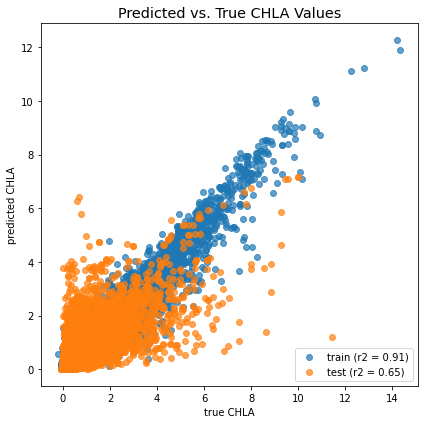

In [19]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(6,6))

if verbose > 0:
    print('XGBoosting regressor trained over the entire euphotic zone')

# obtain train and test data for this bin
train_data_df, train_predictions_for_depth_df = get_data_by_depth(train_df, features=train_features)
test_data_df, test_predictions_for_depth_df = get_data_by_depth(test_df, features=train_features)

# standardize features based on training data
X_train, X_test, y_train, y_test, ss = standardize(train_data_df, test_data_df, return_scaler=True)

if verbose > 0:
    print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
    print(f'Num test samples: {X_test.shape[0]}')

# train, predict, and get scores for XGBoosting regressor
xgbr = XGBRegressor(n_estimators=20, max_depth=12, colsample_bytree=0.7)     # grow_policy = 'depthwise' or 'lossguide'
train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)

for idx, p in enumerate(train_preds):
    if p < 0:
        train_preds[idx] = 0
        
for idx, p in enumerate(test_preds):
    if p < 0:
        test_preds[idx] = 0

if verbose > 0: 
    print(f'\tTrain MSE: {mean_squared_error(y_train, train_preds):.4f}', end='  |  ')
    print(f'Train r2: {r2_score(y_train, train_preds):.4f}')
    print(f'\tTest MSE: {mean_squared_error(y_test, test_preds):.4f}', end='   |  ')
    print(f'Test r2: {r2_score(y_test, test_preds):.4f}')

# plot predictions vs. true values
plot(y_train, train_preds, y_test, test_preds)

# add scores and predictions to respective dataframes
results_df.loc[results_df.shape[0]] = [train_data_df.shape[0] + test_data_df.shape[0]] + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
train_predictions_for_depth_df['pred_CHLA'] = train_preds
train_predictions_df = pd.concat([train_predictions_df, train_predictions_for_depth_df])
test_predictions_for_depth_df['pred_CHLA'] = test_preds
test_predictions_df = pd.concat([test_predictions_df, test_predictions_for_depth_df])

# save the model
model_path = path + 'xgb_single_model/'
model_file = 'xgb_model_std_inputs'
try:
    pickle.dump(xgbr, open(model_path + model_file, 'wb'))
except:
    os.mkdir(model_path)
    pickle.dump(xgbr, open(model_path + model_file, 'wb'))

if verbose > 0:
    print()
        
plt.tight_layout()
plt.show()


In [20]:
# display the dataframe of results
results_df


,num_observations,train_mse,train_r2,test_mse,test_r2
0,423380.0,0.019967,0.908204,0.070555,0.649714


In [21]:
# find R^2 values for various normalized depth bins
bins = np.unique(df['norm'])
for b in bins:
    tmp_df = test_predictions_df[(test_predictions_df['norm'] == b)]
    print(f'Test r2 ({b}): {r2_score(tmp_df["true_CHLA"], tmp_df["pred_CHLA"]):.4f}')
#     plt.figure(figsize=(4,4))
#     plt.scatter(tmp_df['true_CHLA'], tmp_df['pred_CHLA'])
#     plt.show()
    

Test r2 (0.0): 0.6536
Test r2 (0.1): 0.6667
Test r2 (0.2): 0.5953
Test r2 (0.3): 0.5021
Test r2 (0.4): 0.4098
Test r2 (0.5): 0.2614
Test r2 (0.6): 0.0671
Test r2 (0.7): -0.3380
Test r2 (0.8): -3.8823
Test r2 (0.9): -7.7762


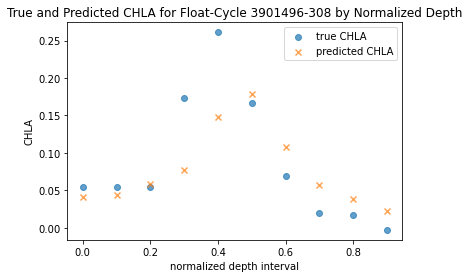

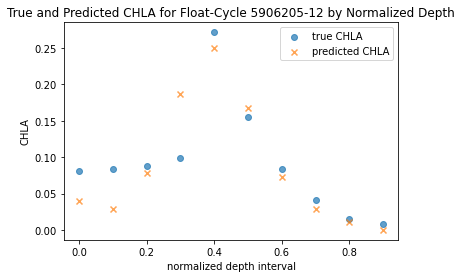

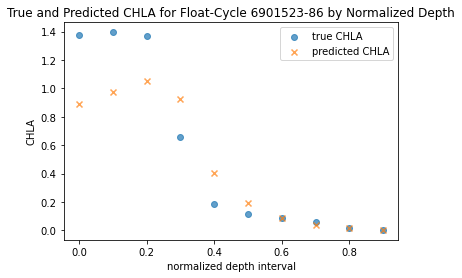

In [22]:
# display results for a few example float-cycles
for f_c in random.choices(test_float_cycles, k=3):
    f, c = f_c.split('_')
    f, c = int(f), int(c)
    tmp_df = test_predictions_df[(test_predictions_df['float'] == f) & (test_predictions_df['cycle'] == c)]
    plt.figure(figsize=(6,4))
    plt.scatter(tmp_df['norm'], tmp_df['true_CHLA'], alpha=0.7, marker='o', label='true CHLA')
    plt.scatter(tmp_df['norm'], tmp_df['pred_CHLA'], alpha=0.7, marker='x', label='predicted CHLA')
    plt.title(f'True and Predicted CHLA for Float-Cycle {f}-{c} by Normalized Depth')
    plt.xlabel('normalized depth interval')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()
    

In [23]:
# save results and predictions
result_path = path + 'results/'
results_df.to_csv(result_path + 'results_xgb_std_inputs_ejd.csv', index=False)
train_predictions_df.to_csv(result_path + 'xgb_std_inputs_train_preds.csv', index=False)
test_predictions_df.to_csv(result_path + 'xgb_std_inputs_test_preds.csv', index=False)


## Inference: the process if given only unseen satellite data

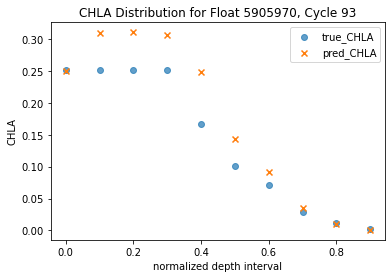

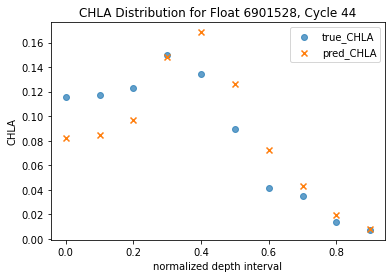

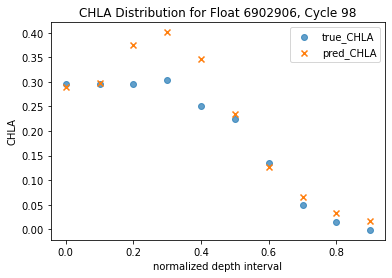

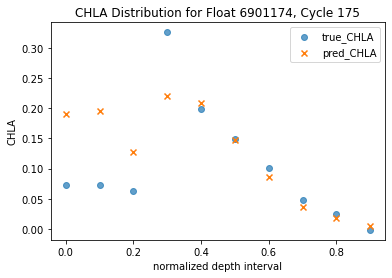

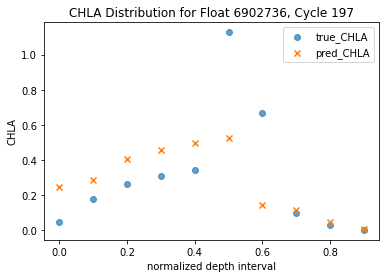

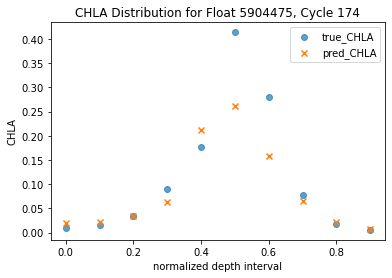

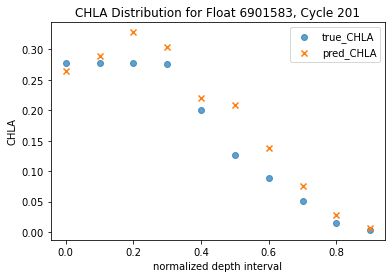

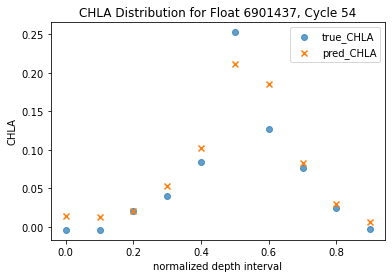

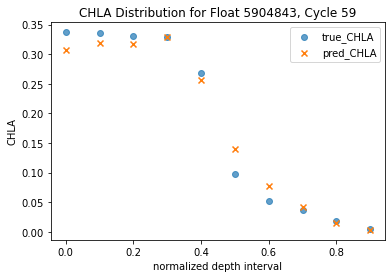

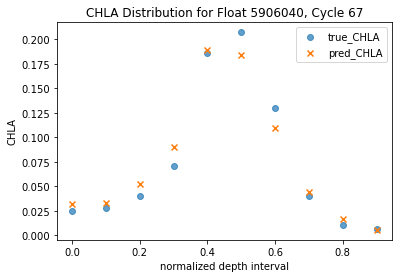

In [24]:
num = 10
for i in range(num):
    # choose a random float-cycle from the test data
    f = random.choice(test_df['float'])
    float_df = test_df[test_df['float']==f]
    c = random.choice(np.unique(float_df['cycle']))
    cycle_df = float_df[float_df['cycle']==c]
    
    # obtain just the features (without raw depth), as if using unseen satellite data
    feats_df = cycle_df[train_features[:-2]].drop_duplicates()
    
    # perform a cross join to get predictions for every 20m of raw depth from the surface to 300m
    depths_df = pd.DataFrame({'input_depth': np.arange(0,1,0.1)})
    feats_df = feats_df.merge(right=depths_df, how='cross')
    
    # standardize features
    std_feats_df = feats_df.copy()
    std_feats_df[std_feats_df.columns] = ss.transform(feats_df[feats_df.columns])
    
    # obtain predictions
    preds = xgbr.predict(std_feats_df)
    
    for idx, p in enumerate(preds):
        if p < 0:
            preds[idx] = 0

    # plot true and predicted CHLA values
    plt.figure(figsize=(6,4))
    plt.scatter(cycle_df['norm'], cycle_df['CHLA'], marker='o', alpha=0.7, label='true_CHLA')
    plt.scatter(feats_df['input_depth'], preds, marker='x', label='pred_CHLA')
    plt.title(f'CHLA Distribution for Float {f}, Cycle {c}')
    plt.xlabel('normalized depth interval')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()


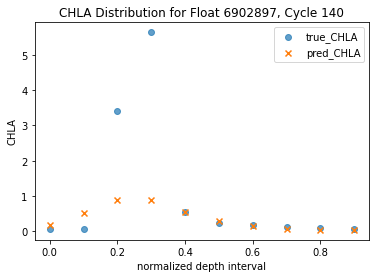

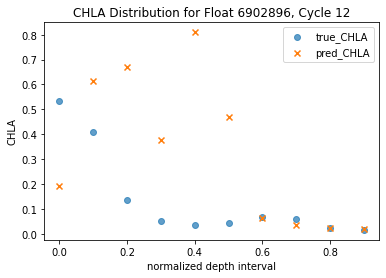

In [25]:
# repeat with some known unusual cycles with missed peaks, for example
unusual_float_cycles = [(6902897, 140), (6902896, 12)]
for i in range(len(unusual_float_cycles)):
    # choose a random float-cycle from the test data
    f, c = unusual_float_cycles[i]
    float_df = test_df[test_df['float']==f]
    cycle_df = float_df[float_df['cycle']==c]
    
    # obtain just the features (without raw depth), as if using unseen satellite data
    feats_df = cycle_df[train_features[:-2]].drop_duplicates()
    
    # perform a cross join to get predictions for every 20m of raw depth from the surface to 300m
    depths_df = pd.DataFrame({'input_depth': np.arange(0,1,0.1)})
    feats_df = feats_df.merge(right=depths_df, how='cross')
    
    # standardize features
    std_feats_df = feats_df.copy()
    std_feats_df[std_feats_df.columns] = ss.transform(feats_df[feats_df.columns])
    
    # obtain predictions
    preds = xgbr.predict(std_feats_df)
    
    for idx, p in enumerate(preds):
        if p < 0:
            preds[idx] = 0

    # plot true and predicted CHLA values
    plt.figure(figsize=(6,4))
    plt.scatter(cycle_df['norm'], cycle_df['CHLA'], marker='o', alpha=0.7, label='true_CHLA')
    plt.scatter(feats_df['input_depth'], preds, marker='x', label='pred_CHLA')
    plt.title(f'CHLA Distribution for Float {f}, Cycle {c}')
    plt.xlabel('normalized depth interval')
    plt.ylabel('CHLA')
    plt.legend()
    plt.show()